In [ ]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from sklearn.svm import SVC
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn import datasets, svm, metrics
from skimage import color

import warnings
warnings.filterwarnings('ignore')

ImportError: ignored

In [ ]:
# !pip install --upgrade opencv-python
# !pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 51.0MB 141kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


     |████████████████████████████████| 57.4MB 112kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!pip install -q tfds-nightly
import tensorflow_datasets as tfds
ds, info = tfds.load('inobus_pet_v5', with_info=True, data_dir='gs://pet_dataset/inobus_pet_v5')

In [ ]:
train_ds, test_ds = ds['train'], ds['test']

In [ ]:
@tf.function
def load_image_label(datapoint):
  img = datapoint['image']
  label = datapoint['label']

  return img, label 

In [ ]:
train_ds = train_ds.map(load_image_label)
test_ds = test_ds.map(load_image_label)

In [ ]:
# 이미지 너무 크니 1/4 으로 줄여줌.
# (2464, 3280, 3) -> (616, 820, 3)
resizer = tf.keras.layers.experimental.preprocessing.Resizing(616, 820)
train_ds = train_ds.map(lambda x, y: (resizer(x), y))
test_ds = test_ds.map(lambda x, y: (resizer(x), y))

In [ ]:
train = tfds.as_numpy(train_ds)
test = tfds.as_numpy(test_ds)

X_train, y_train = zip(*train)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test, y_test = zip(*test)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
X_train = X_train.astype(np.uint8)
X_test = X_test.astype(np.uint8)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(742, 616, 820, 3)
(140, 616, 820, 3)


In [ ]:
print(X_train.dtype)
print(y_train.dtype)
print(X_test.dtype)
print(y_test.dtype)

uint8
int64
uint8
int64


Text(0.5, 1.0, 'is pet: 1')

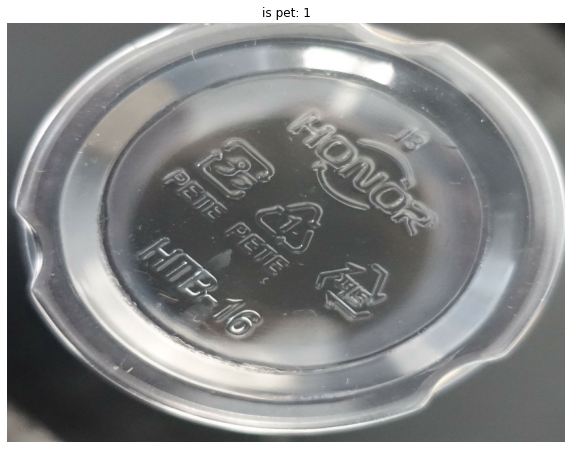

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
ax.imshow(X_train[0])
ax.set_title(f'is pet: {y_train[0]}')

Text(0.5, 1.0, 'is pet: 1')

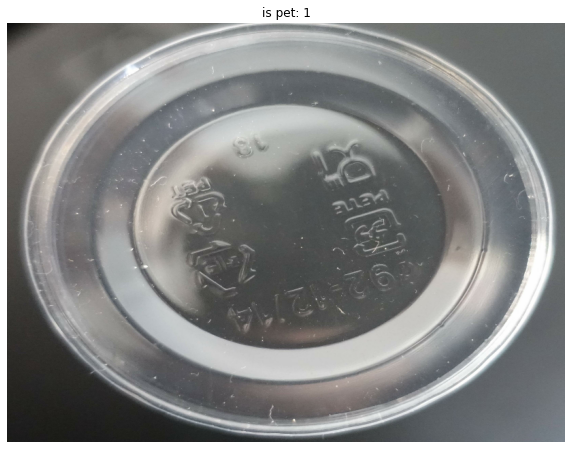

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
ax.imshow(X_train[26])
ax.set_title(f'is pet: {y_train[26]}')

In [ ]:
# Image to gray scale
X_train_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_train])
X_test_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_test])

In [ ]:
print(X_train_gray.shape)

(742, 616, 820)


Text(0.5, 1.0, 'is pet: 1')

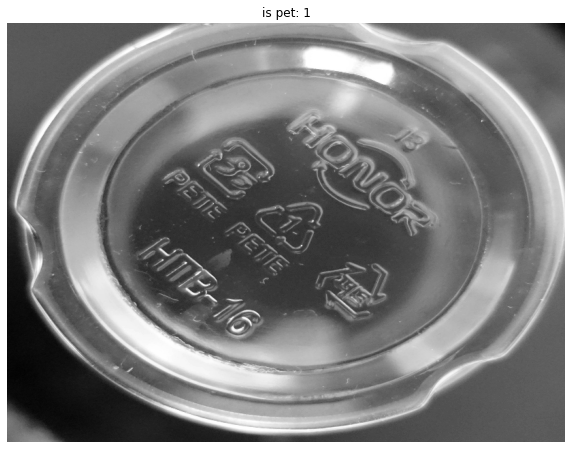

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
ax.imshow(X_train_gray[0], cmap='gray')
ax.set_title(f'is pet: {y_train[0]}')

In [ ]:
sample_img = X_train_gray[120]
sift = cv2.SIFT_create()
kp, desc = sift.detectAndCompute(sample_img, None)

sample_img = cv2.drawKeypoints(sample_img, kp, sample_img)

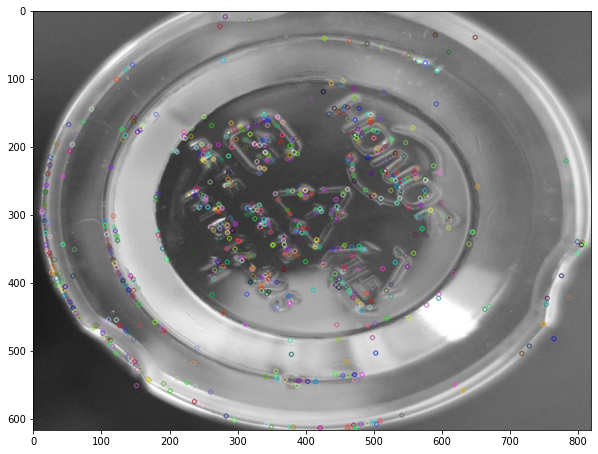

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(sample_img)
plt.show()

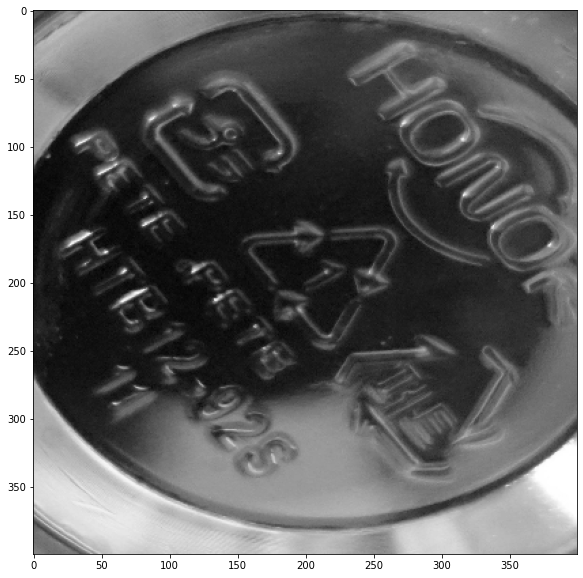

In [ ]:
sample_img = X_train_gray[120][100:500, 200:600]

f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(sample_img, cmap='gray')

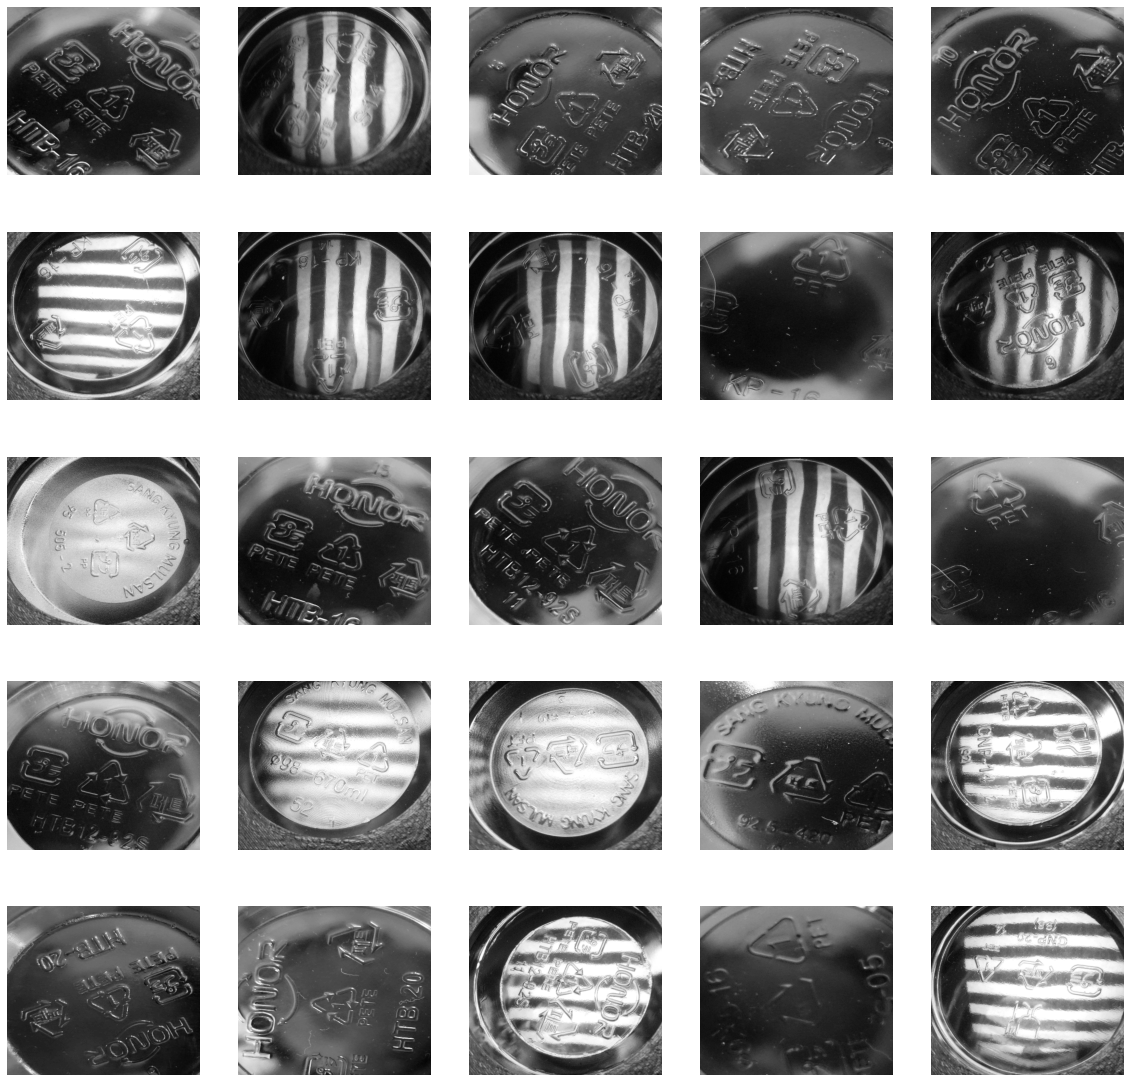

In [ ]:
f, ax = plt.subplots(5, 5, figsize=(20, 20))

for i in range(5):
   for j in range(5):
    sample_img = X_train_gray[i * 5 + j][100:450, 200:600]
    ax[i, j].imshow(sample_img, cmap='gray') 
    ax[i, j].axis('off')
plt.show()

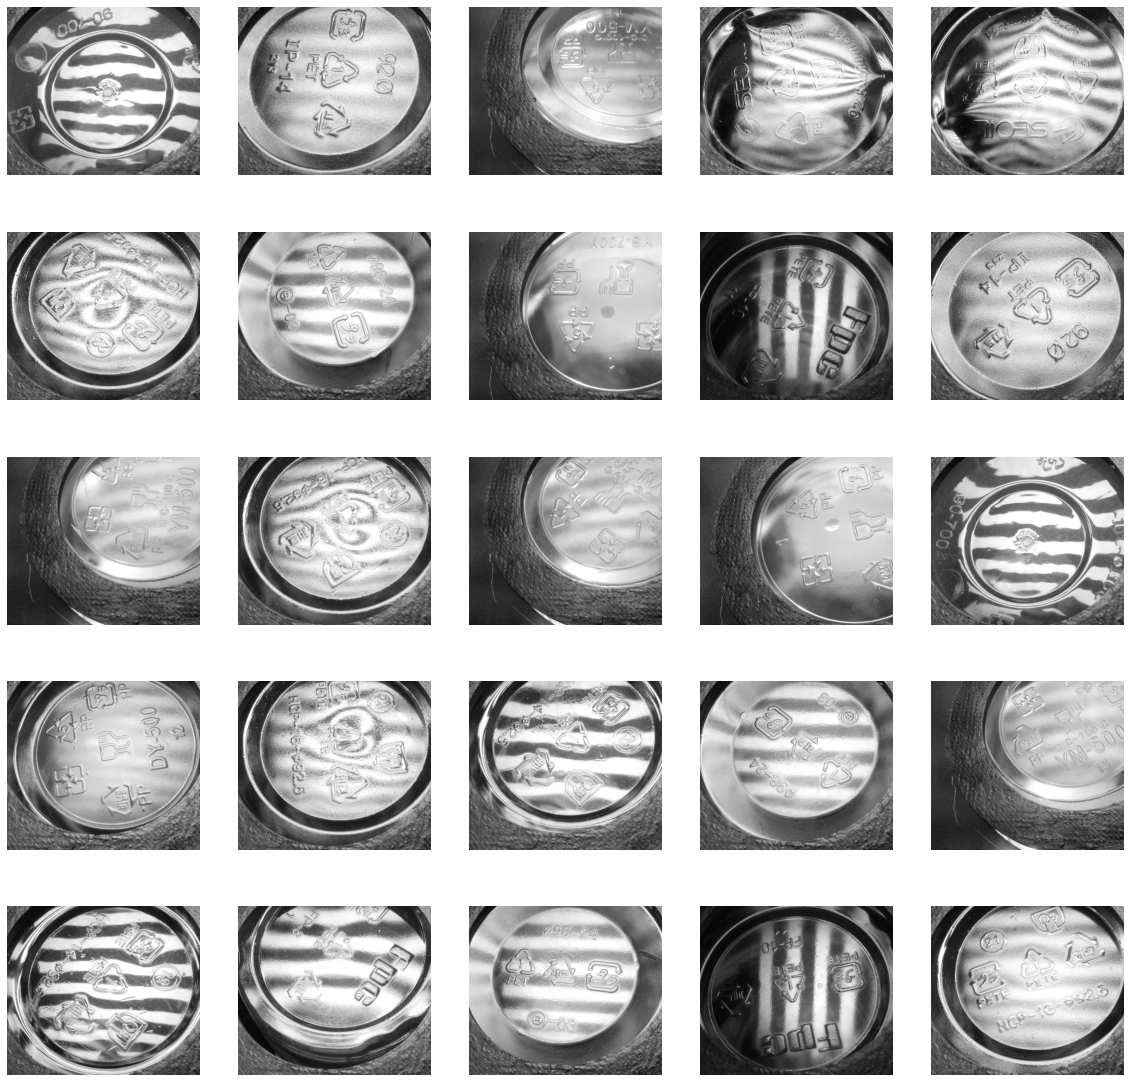

In [ ]:
f, ax = plt.subplots(5, 5, figsize=(20, 20))

for i in range(5):
   for j in range(5):
    sample_img = X_test_gray[i * 5 + j][100:450, 200:600]
    ax[i, j].imshow(sample_img, cmap='gray') 
    ax[i, j].axis('off')
plt.show()

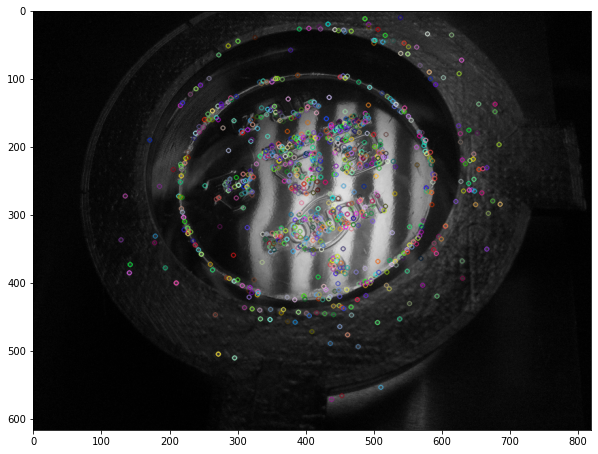

In [ ]:
sample_img = X_train_gray[9]
sift = cv2.SIFT_create()
kp, desc = sift.detectAndCompute(sample_img, None)

sample_img = cv2.drawKeypoints(sample_img, kp, sample_img)

f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(sample_img)
plt.show()

In [ ]:
 X_train_gray_cropped = X_train_gray[:, 100:450, 200:600]
 X_test_gray_cropped = X_test_gray[:, 100:450, 200:600]

In [ ]:
print(X_train_gray_cropped.shape)
print(X_test_gray_cropped.shape)

(742, 350, 400)
(140, 350, 400)


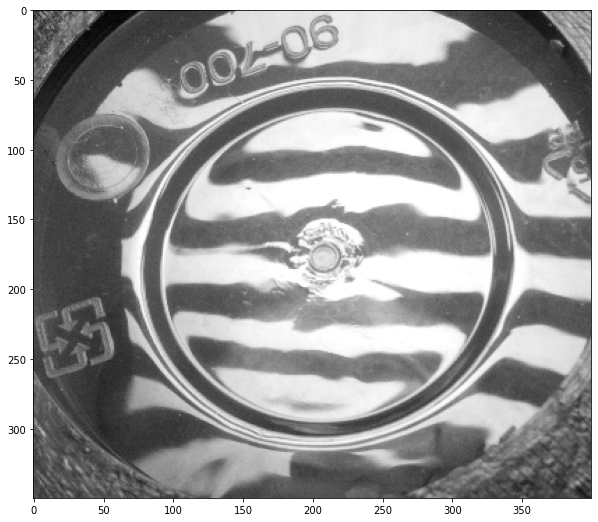

In [ ]:
sample_img = X_test_gray_cropped[0] 

f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(sample_img, cmap='gray')

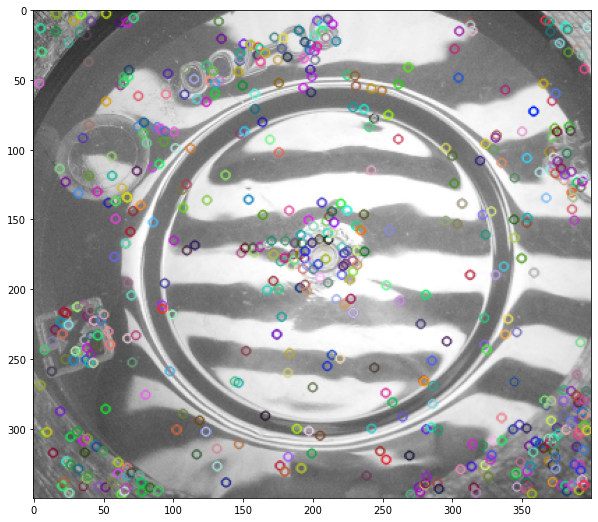

In [ ]:
sample_img = X_test_gray_cropped[0] 

sift = cv2.SIFT_create()
kp, desc = sift.detectAndCompute(sample_img, None)

sample_img = cv2.drawKeypoints(sample_img, kp, sample_img)

f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(sample_img)
plt.show()

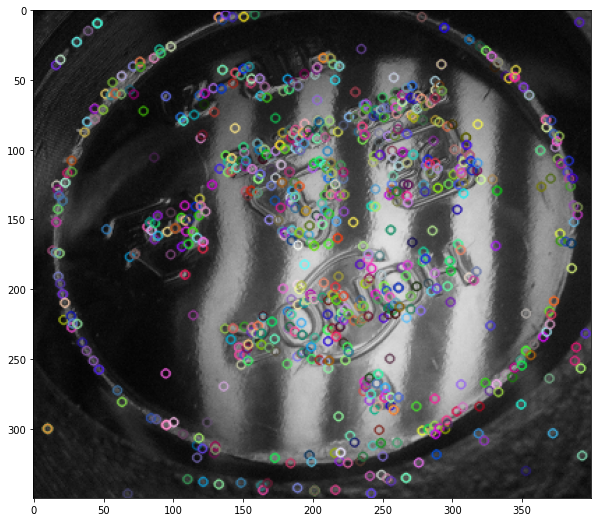

In [ ]:
sample_img = X_train_gray_cropped[9]
sift = cv2.SIFT_create()
kp, desc = sift.detectAndCompute(sample_img, None)

sample_img = cv2.drawKeypoints(sample_img, kp, sample_img)

f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(sample_img)
plt.show()

In [ ]:
def gen_sift_features(X):
  """X is list of gray sacle image."""
  img_descs = []

  for img in X:
    sift = cv2.SIFT_create()
    kp, desc = sift.detectAndCompute(img, None)

    img_descs.append(desc)

  return img_descs

In [ ]:
%%time
train_descs = gen_sift_features(X_train_gray)
test_descs = gen_sift_features(X_test_gray)

train_descs_cropped = gen_sift_features(X_train_gray_cropped)
test_descs_cropped = gen_sift_features(X_test_gray_cropped)

CPU times: user 6min 14s, sys: 16.5 s, total: 6min 30s
Wall time: 2min 59s


In [ ]:
print(train_descs[0].shape)
print(train_descs[1].shape)
print(train_descs[2].shape)

print(test_descs[0].shape)
print(test_descs[1].shape)
print(test_descs[2].shape)

(1069, 128)
(386, 128)
(815, 128)
(2368, 128)
(2781, 128)
(1674, 128)


In [ ]:
# Concatenate all descriptors in the training set together.
all_train_descriptors = np.array([desc for desc_list in train_descs for desc in desc_list])
all_train_descriptors_cropped = np.array([desc for desc_list in train_descs_cropped for desc in desc_list])
print(all_train_descriptors.shape)
print(all_train_descriptors_cropped.shape)

(1015777, 128)
(397649, 128)


In [ ]:
# Cluster the SIFT descriptors.
%%time
K_CLUSTERS = 250
cluster_model = MiniBatchKMeans(n_clusters=K_CLUSTERS)
cluster_model.fit(all_train_descriptors)

CPU times: user 2min 40s, sys: 4min 57s, total: 7min 37s
Wall time: 1min 57s


In [ ]:
# Compute set of cluster-reduced for each image.
train_clustered_words = [cluster_model.predict(raw_words) for raw_words in train_descs]
test_clustered_words = [cluster_model.predict(raw_words) for raw_words in test_descs]

In [ ]:
# Make a historgram of clustered word counts for each image.
n_clusters = cluster_model.n_clusters
train_bow_hist = np.array([np.bincount(clustered_words, minlength=n_clusters) for clustered_words in train_clustered_words])
test_bow_hist = np.array([np.bincount(clustered_words, minlength=n_clusters) for clustered_words in test_clustered_words])

## Cropped part

In [ ]:
# Cluster the SIFT descriptors.
%%time
K_CLUSTERS = 250
cluster_model_cropped = MiniBatchKMeans(n_clusters=K_CLUSTERS)
cluster_model_cropped.fit(all_train_descriptors_cropped)

CPU times: user 1min 7s, sys: 2min 5s, total: 3min 13s
Wall time: 49 s


In [ ]:
train_clustered_words_cropped = [cluster_model_cropped.predict(raw_words) for raw_words in train_descs_cropped]
test_clustered_words_cropped = [cluster_model_cropped.predict(raw_words) for raw_words in test_descs_cropped]

In [ ]:
n_clusters = cluster_model_cropped.n_clusters
train_bow_hist_cropped = np.array([np.bincount(clustered_words, minlength=n_clusters) for clustered_words in train_clustered_words_cropped])
test_bow_hist_cropped = np.array([np.bincount(clustered_words, minlength=n_clusters) for clustered_words in test_clustered_words_cropped])

In [ ]:
n_clusters = cluster_model_cropped.n_clusters
train_bow_hist_cropped = np.array([np.bincount(clustered_words, minlength=n_clusters) for clustered_words in train_clustered_words_cropped])
test_bow_hist_cropped = np.array([np.bincount(clustered_words, minlength=n_clusters) for clustered_words in test_clustered_words_cropped])

In [ ]:
%%time

# Classify with SVM.

kernels = ['linear', 'rbf']
c_vals = [0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1] 
gamma_vals =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

svcs = []
svc_accuracies = []

for kernel in kernels:
  for C in c_vals:
    for gamma in gamma_vals:
      if kernel == 'linear':
        svc = SVC(C=C, kernel=kernel)
      else:
        svc = SVC(C=C, kernel=kernel, gamma=gamma)
      
      svc.fit(train_bow_hist, y_train)
      svcs.append(svc)
      svc_accuracies.append(metrics.accuracy_score(svc.predict(test_bow_hist), y_test))


CPU times: user 39.3 s, sys: 57.5 ms, total: 39.3 s
Wall time: 39.2 s


In [ ]:
max(svc_accuracies)

0.8642857142857143

In [ ]:
%%time

# Cropped
# Classify with SVM.

kernels = ['linear', 'rbf']
c_vals = [0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1] 
gamma_vals =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

svcs_cropped = []
svc_accuracies_cropped = []

for kernel in kernels:
  for C in c_vals:
    for gamma in gamma_vals:
      if kernel == 'linear':
        svc = SVC(C=C, kernel=kernel)
      else:
        svc = SVC(C=C, kernel=kernel, gamma=gamma)
      
      svc.fit(train_bow_hist_cropped, y_train)
      svcs_cropped.append(svc)
      svc_accuracies_cropped.append(metrics.accuracy_score(svc.predict(test_bow_hist_cropped), y_test))


CPU times: user 40.1 s, sys: 37.8 ms, total: 40.1 s
Wall time: 39.9 s


In [ ]:
max(svc_accuracies_cropped)

0.8071428571428572

In [ ]:
%%time

estimator_vals = list(range(100,1100,100))
lrs = [0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]

# AdaBoostClassifier
adas = []
ada_accuracies = []

for n_estimators in estimator_vals:
  for learning_rate in lrs:
    ada = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate)
    ada.fit(train_bow_hist, y_train)
    adas.append(ada)
    ada_accuracies.append(metrics.accuracy_score(ada.predict(test_bow_hist), y_test))


CPU times: user 9min 21s, sys: 2.89 s, total: 9min 24s
Wall time: 9min 22s


In [ ]:
max(ada_accuracies)

0.8642857142857143

In [ ]:
%%time

estimator_vals = list(range(100,1100,100))
lrs = [0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]

# AdaBoostClassifier
adas_cropped = []
ada_accuracies_cropped = []

for n_estimators in estimator_vals:
  for learning_rate in lrs:
    ada = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate)
    ada.fit(train_bow_hist_cropped, y_train)
    adas_cropped.append(ada)
    ada_accuracies_cropped.append(metrics.accuracy_score(ada.predict(test_bow_hist_cropped), y_test))


CPU times: user 8min 15s, sys: 3.15 s, total: 8min 18s
Wall time: 8min 16s


In [ ]:
max(ada_accuracies_cropped)

0.7714285714285715